# Setup

In [ ]:
import itertools

import pandas as pd
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
plot_params = {'legend.fontsize': 20,
               'figure.figsize': (20, 10),
               'axes.labelsize':  15,
               'axes.titlesize':  30,
               'xtick.labelsize': 15,
               'ytick.labelsize': 15,
               'figure.dpi': 300}

plt.style.use('seaborn-v0_8')

#plt.rcParams.update(plot_params)

color_dark_blue = [1/255, 62/255, 125/255]
color_light_blue = [6/255, 143/255, 203/255]
purple = [102/255, 51/255, 153/255]

colors = [color_dark_blue, color_light_blue, purple]

color_line = list(itertools.product(['-', ':', '--', ':' '-', ':'], colors))

# Load Data

Data from:

https://www.kaggle.com/code/calven22/forecasting-inflation-with-arima-and-lstm/input

In [ ]:
df = pd.read_csv('macro_monthly.csv', index_col=0).dropna()
df.index = pd.DatetimeIndex(df.index).to_period('M')

In [ ]:
df.columns

Index(['unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer', 'tcs',
       'indpro', 'ccpi'],
      dtype='object')

In [ ]:
df.columns = ['Unemployment Rate',
'Personal Saving Rate',
'M2','Disposable Income',
 'Personal Consumption Expenditure',
 'Real Effective Exchange Rate',
 '10Y Treasury Yield',
 'Fed Rate',
 'Construction Spending',
 'Industrial Production Index',
 'Core CPI']

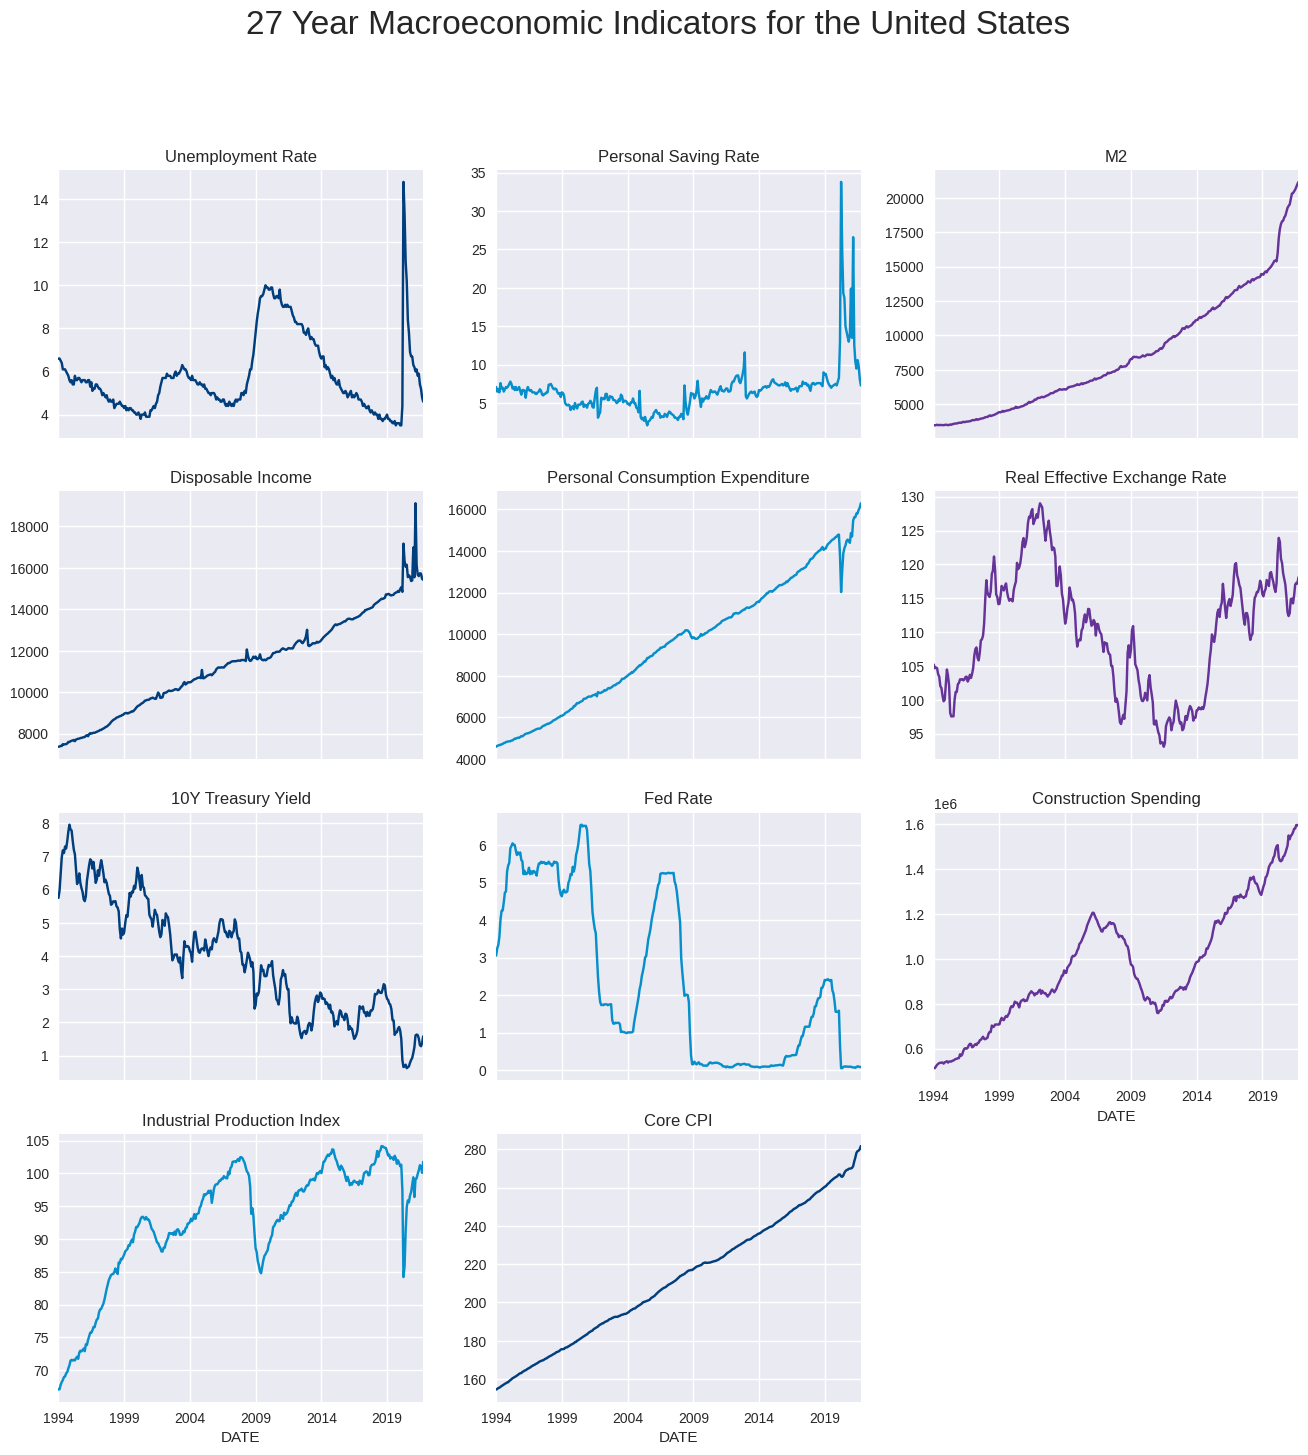

In [ ]:
df.plot(subplots = True,
        figsize = (16,16),
        legend = False,
        title = list(df.columns),
        layout = (4,3),
        sharex = True,
        color = colors * 3 + [color_light_blue])

plt.suptitle('27 Year Macroeconomic Indicators for the United States', fontsize = 24);

In [ ]:
df = df[['Real Effective Exchange Rate', '10Y Treasury Yield', 'Core CPI']].dropna()
df.columns = ['Exchange Rate', '10Y Yield', 'CPI']

In [ ]:
n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):int(n*0.9)]
test_df = df[int(n*0.9):]

# Augmented Dickey–Fuller Stationarity Test

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [ ]:
# ADF Test on each column
for name, column in train_df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Exchange Rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.4159
 No. Lags Chosen       = 2
 Critical value 1%     = -3.455
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.5747. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "10Y Yield" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.246
 No. Lags Chosen       = 5
 Critical value 1%     = -3.456
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.6535. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data

In [ ]:
train_df_stationary = train_df.diff().dropna()

In [ ]:
# ADF Test on each column
for name, column in train_df_stationary.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Exchange Rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.6083
 No. Lags Chosen       = 1
 Critical value 1%     = -3.455
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "10Y Yield" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.1745
 No. Lags Chosen       = 4
 Critical value 1%     = -3.456
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Le

# Vector Autoregressive (VAR)

In [ ]:
model = VAR(train_df_stationary)

In [ ]:
model.select_order(maxlags=15).summary()

,AIC,BIC,FPE,HQIC
0,-6.167,-6.125,0.002097,-6.150
1,-6.310,-6.142*,0.001818,-6.242*
2,-6.317*,-6.022,0.001806*,-6.198
3,-6.274,-5.852,0.001886,-6.104
4,-6.221,-5.674,0.001987,-6.001
5,-6.220,-5.546,0.001990,-5.949
6,-6.176,-5.376,0.002080,-5.854
7,-6.194,-5.267,0.002044,-5.821
8,-6.189,-5.136,0.002056,-5.765
9,-6.129,-4.949,0.002186,-5.654


In [ ]:
model_fitted = model.fit()
lag_order = model_fitted.k_ar

In [ ]:
lag_order

1

In [ ]:
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, Nov, 2023
Time:                     20:08:39
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -6.12312
Nobs:                     265.000    HQIC:                  -6.22009
Log likelihood:          -283.265    FPE:                 0.00186367
AIC:                     -6.28522    Det(Omega_mle):      0.00178176
--------------------------------------------------------------------
Results for equation Exchange Rate
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.128299         0.186447            0.688           0.491
L1.Exchange Rate         0.351419         0.058558            6.001           0.000
L1.10Y Yield            -0.187936       

## Durbin-Watson

In [ ]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(train_df_stationary.columns, out):
    print(col, ':', round(val, 2))

Exchange Rate : 1.9
10Y Yield : 1.96
CPI : 2.03


## Impulse Response Function

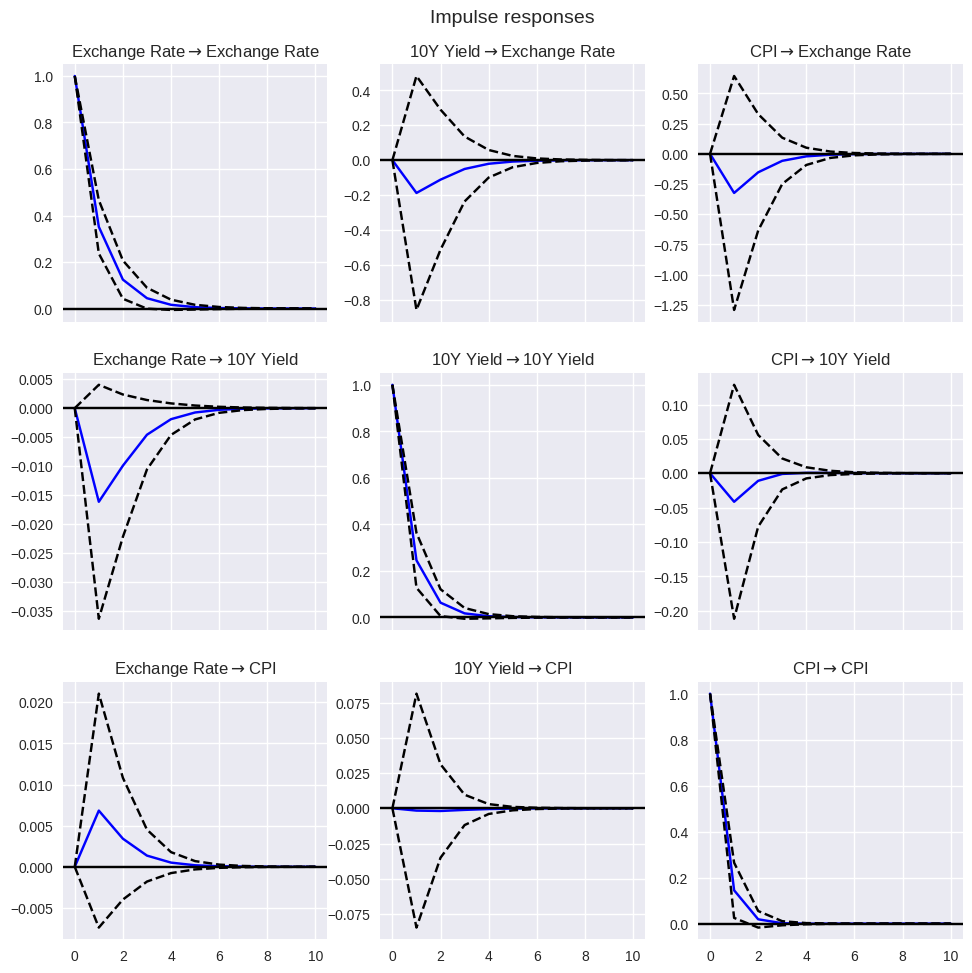

In [ ]:
irf = model_fitted.irf(10)
_ = irf.plot(orth=False)

# Granger's Causality

In [ ]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', maxlag=8):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [ ]:
grangers_causation_matrix(train_df_stationary, variables = train_df_stationary.columns)

,Exchange Rate_x,10Y Yield_x,CPI_x
Exchange Rate_y,1.0000,0.0611,0.1283
10Y Yield_y,0.1114,1.0000,0.4469
CPI_y,0.2539,0.4757,1.0000


# Forecasting

## Validation

In [ ]:
val_df_stationary = val_df.diff().dropna()

forecast_window = 1

df_results = pd.DataFrame(columns=train_df_stationary.columns, index=val_df.index)

df_forecast = pd.DataFrame(columns=train_df_stationary.columns, index=val_df.index)

forecast_input = train_df_stationary.values[-lag_order:]
fc = model_fitted.forecast(y=forecast_input, steps=forecast_window)
df_forecast.iloc[0,:] = fc
df_results.iloc[0,:] = train_df.iloc[-1,:].values + fc[0]

for i in range(1,len(val_df)):

    forecast_input = val_df_stationary.values[i-lag_order:i]
    fc = model_fitted.forecast(y=forecast_input, steps=forecast_window)
    df_forecast.iloc[i,:] = fc

    df_results.iloc[i,:] = val_df.iloc[i-1,:] + fc[0]

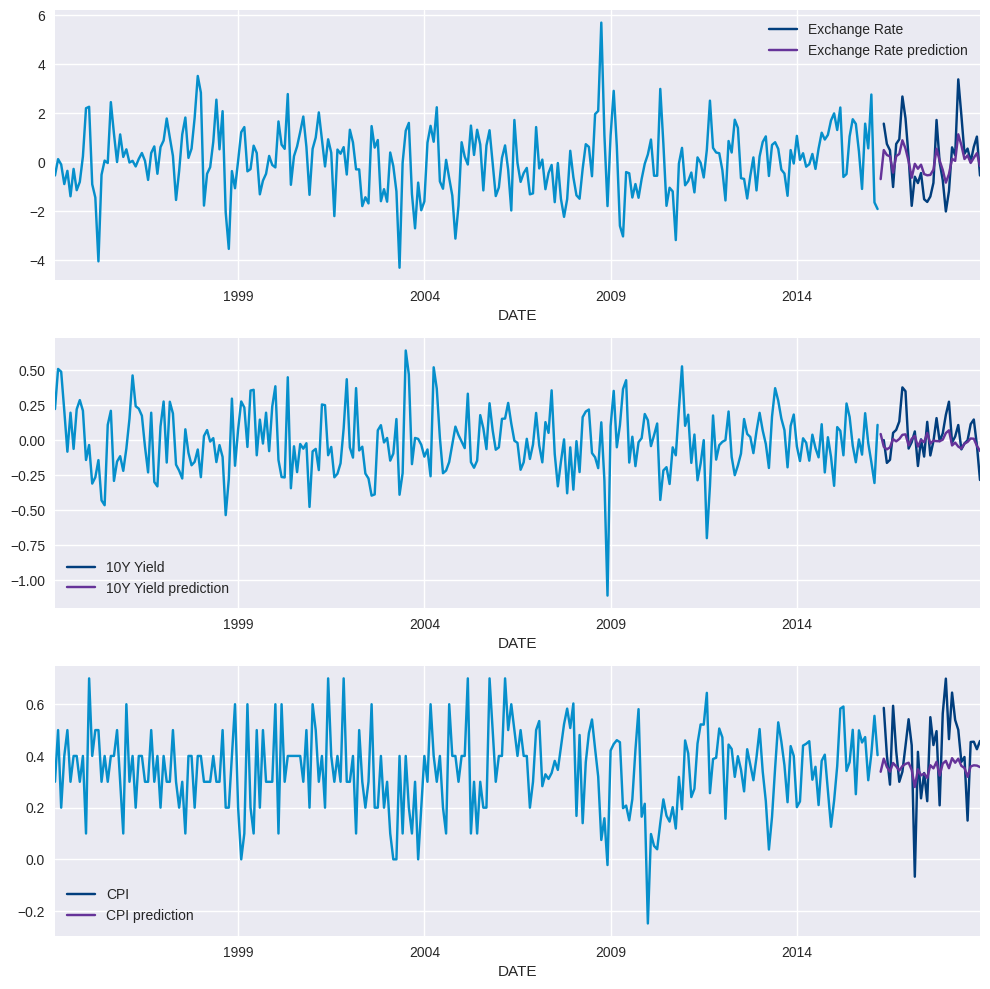

In [ ]:
fig, axes = plt.subplots(nrows=3,figsize=(10,10))
for i, (col,ax) in enumerate(zip(train_df_stationary.columns, axes.flatten())):
    val_df_stationary[col].plot(legend=True, ax=ax, color=color_dark_blue);
    train_df_stationary[col].plot(legend=False, ax=ax, color=color_light_blue);
    df_forecast[col].plot(legend=True, ax=ax, color=purple, label=col+ ' prediction').autoscale(axis='x',tight=True);

plt.tight_layout();

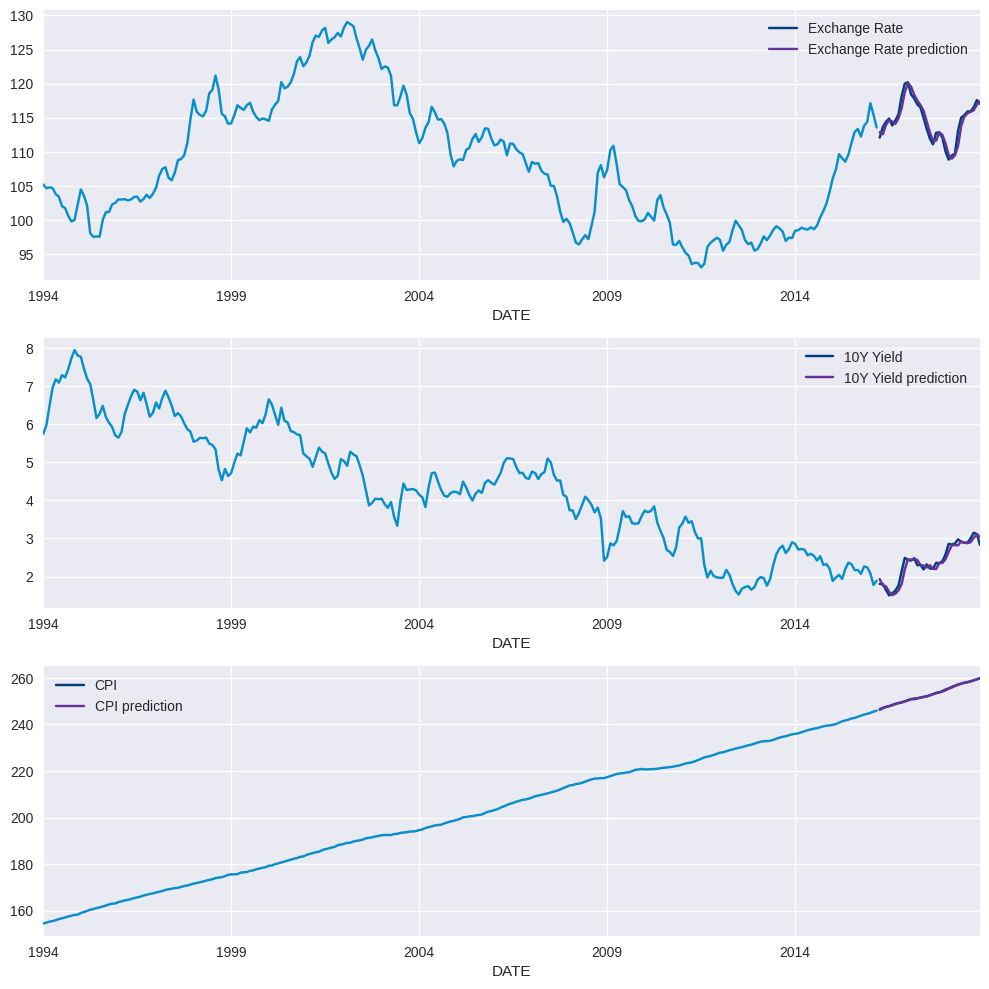

In [ ]:
fig, axes = plt.subplots(nrows=3,figsize=(10,10))
for i, (col,ax) in enumerate(zip(train_df_stationary.columns, axes.flatten())):
    val_df[col].plot(legend=True, ax=ax, color=color_dark_blue);
    train_df[col].plot(legend=False, ax=ax, color=color_light_blue);
    df_results[col].plot(legend=True, ax=ax, color=purple, label=col+ ' prediction').autoscale(axis='x',tight=True);

plt.tight_layout();

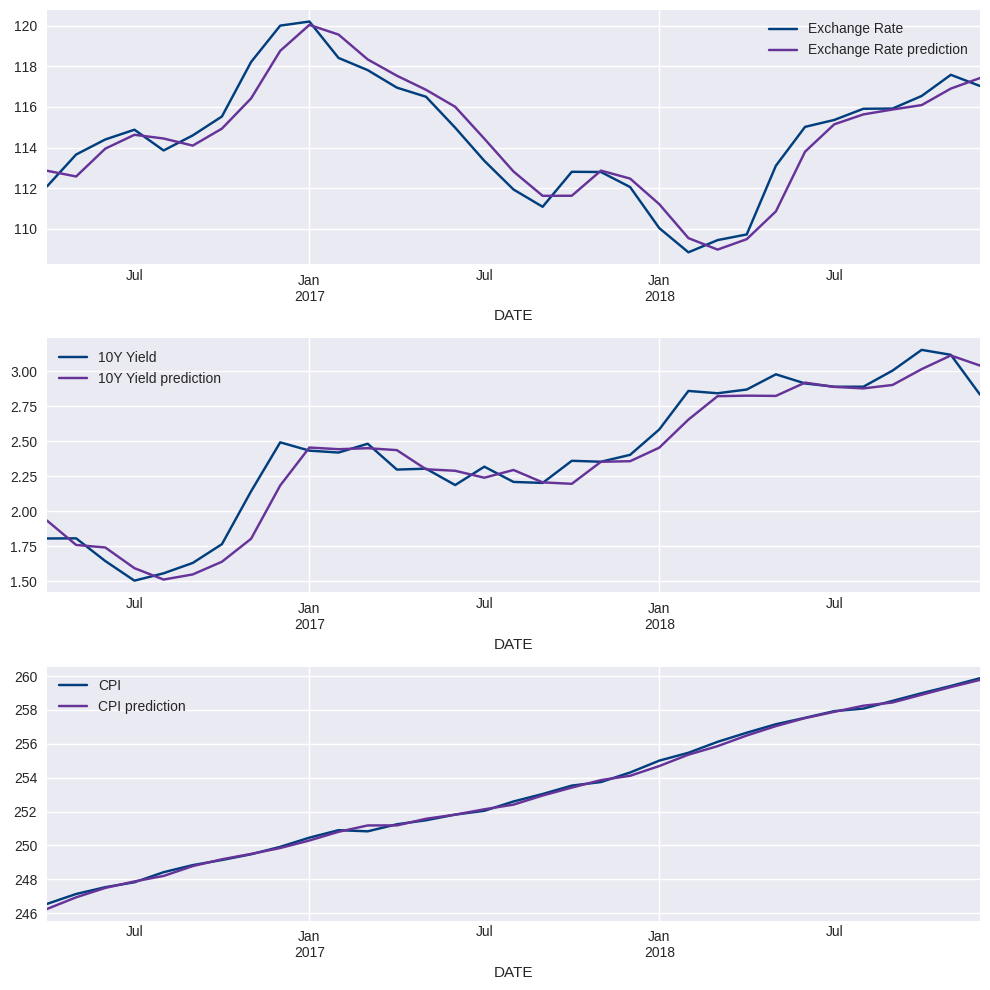

In [ ]:
fig, axes = plt.subplots(nrows=3,figsize=(10,10))
for i, (col,ax) in enumerate(zip(train_df_stationary.columns, axes.flatten())):
    val_df[col].plot(legend=True, ax=ax, color=color_dark_blue);
    #train_df[col].plot(legend=False, ax=ax, color=color_light_blue);
    df_results[col].plot(legend=True, ax=ax, color=purple, label=col+ ' prediction').autoscale(axis='x',tight=True);

plt.tight_layout();

## Test